In [1]:
import math
import numpy as np

import mido
import librosa
import librosa.display

import IPython.display as ipd
import matplotlib.pyplot as plt
from torch import optim

import torch.nn.functional as F
from torch import nn
import torch

windowSize=50

In [37]:
y, sr = librosa.load('4Beats2MelLong3.wav')

In [38]:
D = librosa.stft(y)

In [39]:
#ipd.Audio(y_hat,rate=sr) # load a local WAV file
ipd.Audio(y,rate=sr) # load a local WAV file

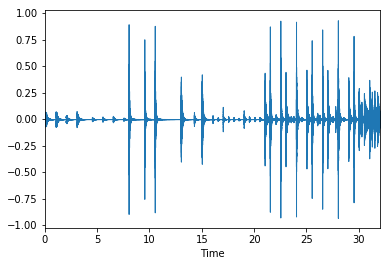

In [40]:
librosa.display.waveplot(y, sr=sr);

In [41]:
midiArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2MelLong3.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
        

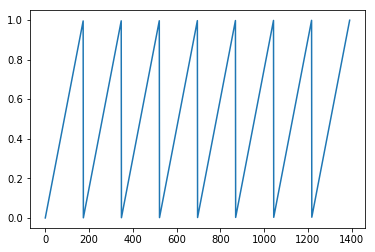

In [42]:
midiArray=np.float32(np.array(midiArray))


plt.plot(midiArray[:,127])
plt.show()

In [43]:
D_t=np.array(D.T)
minLength = min(midiArray.shape[0],D_t.real.shape[0])
#D_data=D_t[:minLength].real;

midiArray=midiArray[:minLength];


In [44]:
D_data=[]
for elem in D_t[:minLength]:
    temp=np.append(np.float32(elem.real),np.float32(elem.imag))
    D_data.append(temp)
D_data=np.array(D_data)

In [45]:
print(D_t.shape,midiArray.shape)
print(midiArray.shape,D_data.shape)
print(midiArray.dtype,D_data.dtype)

(1379, 1025) (1379, 128)
(1379, 128) (1379, 2050)
float32 float32


In [46]:

outPutMidiArray=[]
for i in range(midiArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiArray.shape[0]):
             temp.append(np.zeros(midiArray.shape[1]))
        else:
            temp.append(midiArray[val])
    outPutMidiArray.append(temp)
outPutMidiArray=np.array(outPutMidiArray)

In [47]:
print(outPutMidiArray.shape)

(1379, 50, 128)


In [13]:
## Solution

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(128*windowSize, int(128*windowSize/2))
        self.fc2 = nn.Linear(int(128*windowSize/2), 2000)
        self.fc3 = nn.Linear(2000, 2050)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=2050, bias=True)
)

In [48]:
import torch.utils.data as utils


tensor_x = torch.stack([torch.Tensor(i) for i in np.abs(outPutMidiArray)]) # transform to torch tensors
tensor_y = torch.stack([torch.Tensor(i) for i in np.abs(D_data)])
tensor_x = tensor_x.view(tensor_x.shape[0],-1)
print(tensor_x.shape,tensor_y.shape)
my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = utils.DataLoader(my_dataset,batch_size=64,shuffle=True) # create your dataloader

my_testloader = utils.DataLoader(my_dataset) # create your dataloader


# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
# or criterion = nn.MSELoss()
# Get our data


torch.Size([1379, 6400]) torch.Size([1379, 2050])


In [49]:
plt.plot(tensor_x.numpy()[:,127])
plt.show()

In [17]:
##Reset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Counter=0;
LossOverEpoch=[]
model.train()
model.to(device)

Network(
  (fc1): Linear(in_features=6400, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=2050, bias=True)
)

In [50]:
epochs = 1000
model.train()
for i in range(epochs):
    running_loss = 0
    for data, labels in my_dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()     
        logits = model(data)
        loss =criterion(logits,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        LossOverEpoch.append(running_loss)
        print(str(f"Training loss: {running_loss/len(my_dataloader)}" +"   "+ str(Counter)))
        Counter+=1

Training loss: 1.2774716532931039e+26   2100
Training loss: 0.9435143883932721   2101
Training loss: 0.9306378940289671   2102
Training loss: 0.9102662844075398   2103
Training loss: 0.9116336845538833   2104
Training loss: 0.9124031496996229   2105
Training loss: 0.9109404710206118   2106
Training loss: 0.9180529388514432   2107
Training loss: 0.9126645621250976   2108
Training loss: 0.9241100197488611   2109
Training loss: 0.9500009221109477   2110
Training loss: 0.9358475411480124   2111
Training loss: 0.947214702990922   2112
Training loss: 0.9171437404372476   2113
Training loss: 0.9398503371260383   2114
Training loss: 0.9192471538077701   2115
Training loss: 0.9154489521275867   2116
Training loss: 0.9113281331109729   2117
Training loss: 0.9415791468186812   2118
Training loss: 0.914822755889459   2119
Training loss: 0.9327302178875967   2120
Training loss: 0.9386140268973329   2121
Training loss: 0.9191206680102781   2122
Training loss: 0.9271549738266252   2123
Training loss:

Training loss: 0.9140073108402166   2302
Training loss: 0.9487243071198463   2303
Training loss: 0.9413978247479959   2304
Training loss: 0.9165635549209334   2305
Training loss: 0.9131626019423659   2306
Training loss: 0.9243961599740115   2307
Training loss: 0.9284553575244817   2308
Training loss: 0.9380789016458121   2309
Training loss: 0.9114517525515773   2310
Training loss: 0.9592379250309684   2311
Training loss: 0.9738333970308304   2312
Training loss: 0.91307743774219   2313
Training loss: 0.9446866952560165   2314
Training loss: 0.9374578195539388   2315
Training loss: 0.9145627763460983   2316
Training loss: 0.9149643304673108   2317
Training loss: 0.9149543527852405   2318
Training loss: 0.970090543681925   2319
Training loss: 0.9535278312184594   2320
Training loss: 0.9342824547466907   2321
Training loss: 0.9304777410897341   2322
Training loss: 0.9157493202523752   2323
Training loss: 0.9368440894918009   2324
Training loss: 0.9494648033922369   2325
Training loss: 0.92

Training loss: 0.9498794668100097   2504
Training loss: 0.9272742752324451   2505
Training loss: 0.9222984307191588   2506
Training loss: 0.9388888986273245   2507
Training loss: 0.9206939786672592   2508
Training loss: 0.9173687279901721   2509
Training loss: 0.9106297611512921   2510
Training loss: 0.9390132393349301   2511
Training loss: 0.9256581779230725   2512
Training loss: 0.911137520250949   2513
Training loss: 0.9165892438455061   2514
Training loss: 0.9338598850775849   2515
Training loss: 0.9279316704381596   2516
Training loss: 0.976725067266009   2517
Training loss: 0.9327117313038219   2518
Training loss: 0.9130450683561239   2519
Training loss: 0.9447671676223929   2520
Training loss: 0.9423989673907106   2521
Training loss: 0.9131615598770705   2522
Training loss: 0.9475498280741952   2523
Training loss: 0.9348498352549293   2524
Training loss: 0.9431015368212353   2525
Training loss: 0.9211137023839083   2526
Training loss: 0.9143089076334779   2527
Training loss: 0.9

Training loss: 0.9133767533031377   2706
Training loss: 0.9430290480906313   2707
Training loss: 0.9555805609984831   2708
Training loss: 0.936697396365079   2709
Training loss: 0.955604728649963   2710
Training loss: 0.9291322163560174   2711
Training loss: 0.9187341610139067   2712
Training loss: 0.911695100705732   2713
Training loss: 0.9189045110886748   2714
Training loss: 0.923057805408131   2715
Training loss: 0.9248067966916345   2716
Training loss: 0.9208882312205705   2717
Training loss: 0.9109681925990365   2718
Training loss: 0.9749056866223161   2719
Training loss: 0.9106940793042834   2720
Training loss: 0.9466137648983435   2721
Training loss: 0.9858618531037461   2722
Training loss: 0.9323687248609283   2723
Training loss: 0.9453436305577104   2724
Training loss: 0.942850305952809   2725
Training loss: 0.921739535914226   2726
Training loss: 0.9292565868659453   2727
Training loss: 0.9286705187775872   2728
Training loss: 0.9363895695317875   2729
Training loss: 0.93438

Training loss: 0.9224633124064315   2908
Training loss: 0.9509875374761495   2909
Training loss: 0.933135063810782   2910
Training loss: 0.9116826399483464   2911
Training loss: 0.9213983123614029   2912
Training loss: 0.9187197949398648   2913
Training loss: 0.9194194044579159   2914
Training loss: 0.9461964998732914   2915
Training loss: 0.9156199964610013   2916
Training loss: 0.9114538847722791   2917
Training loss: 0.9323067885230888   2918
Training loss: 0.9177685644138943   2919
Training loss: 0.9195020212368532   2920
Training loss: 0.9510160586373373   2921
Training loss: 0.913848461752588   2922
Training loss: 0.9417194131423127   2923
Training loss: 0.9350846870379015   2924
Training loss: 0.9186213571916927   2925
Training loss: 0.9740039950067346   2926
Training loss: 0.916685363785787   2927
Training loss: 0.952562882818959   2928
Training loss: 0.9422006126154553   2929
Training loss: 0.9339180202646689   2930
Training loss: 0.9492920095270331   2931
Training loss: 0.910

In [60]:
plt.plot(LossOverEpoch[2101:])
plt.show()
#torch.save(model.state_dict(), './w10-3270Epochs.model')

In [52]:
model.eval()
outputArray=[]
for data, labels in my_testloader:
    with torch.no_grad():
        data, labels = data.to(device), labels.to(device)
        output = model.forward(data)
        outputArray.append(output[0].cpu().numpy())
outputArray=np.array(outputArray)

In [53]:
plt.imshow(outputArray)

In [54]:
transformedArray=[]
for elem in outputArray:
    a=np.array(1025 *[1+1j])
    a.real=elem[:1025]
    a.imag=elem[1025:]
    transformedArray.append(a)
transformedArray=np.array(transformedArray).T

In [55]:
print((transformedArray).shape)
Y_infered = librosa.istft(transformedArray) 

(1025, 1379)


In [56]:
ipd.Audio(Y_infered,rate=sr)

/home/far-lab/.local/lib/python3.6/site-packages/IPython/lib/display.py:136: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


In [57]:
ipd.Audio(y,rate=sr)

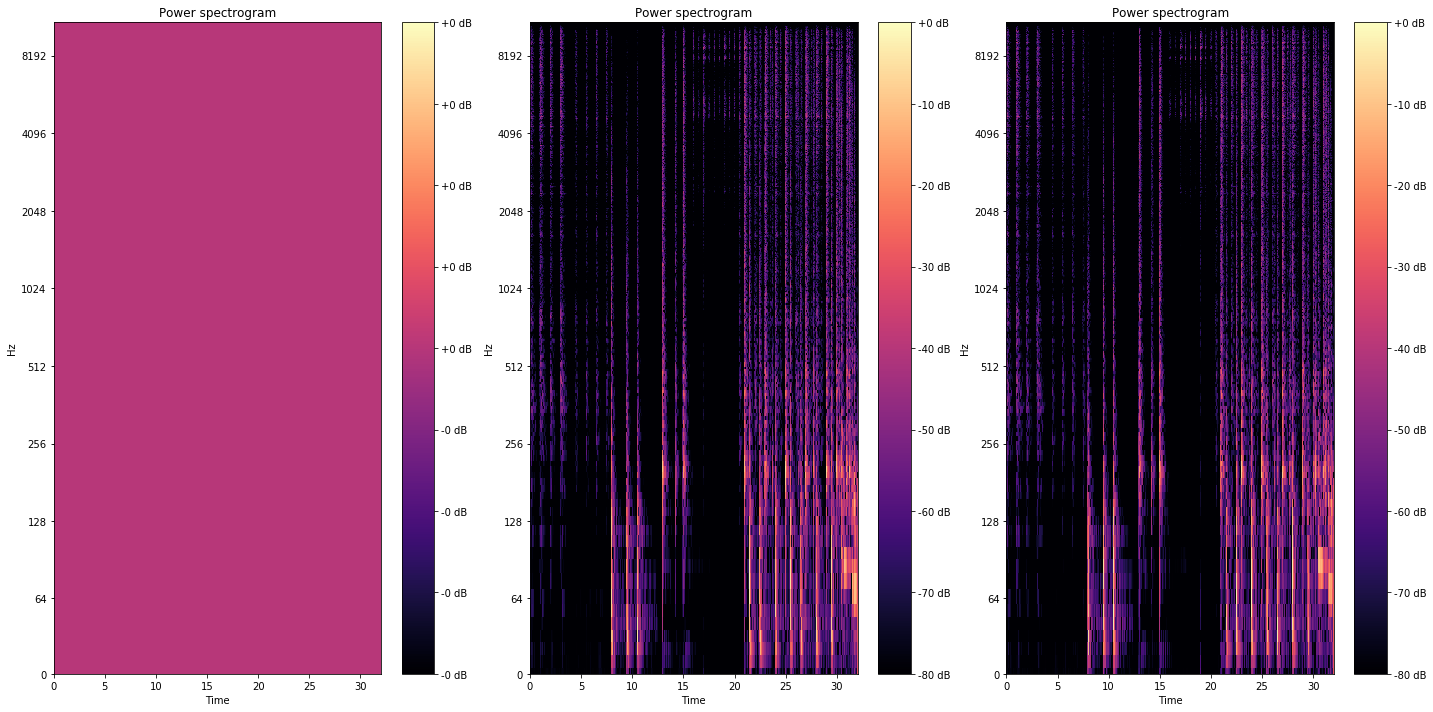

In [58]:

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(transformedArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,3,2)
librosa.display.specshow(librosa.amplitude_to_db(D.real,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


plt.subplot(1,3,3)
librosa.display.specshow(librosa.amplitude_to_db(tensor_y.numpy()[:,:1025].T,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


In [ ]:
output=np.array(0);
with torch.no_grad():
        test=torch.zeros([1, 128*windowSize], dtype=torch.float32)
       # test[0][46]=0.0;
        output = model.forward(test)
      #  test2=torch.ones([1, 1025], dtype=torch.float32)
      #  test2[0][46]=0.0;
        loss = criterion(output,torch.zeros([1, 1025], dtype=torch.float32))
        print(loss.item())
print(output.numpy()[0].shape,D_data[250].shape)
plt.plot(output.numpy()[0],'r')
#plt.plot(D_data[250],'g')
plt.show()

In [ ]:
plt.imshow(outPutMidiArray[60].T)
plt.show()

In [ ]:
midiTestArray=[]
HopSize=0.023
timeTracker=0.0
totalTimeTracker=0.0
MemoryArray=np.zeros(128)
lasttime=0;
bpm=60
for msg in mido.MidiFile('4Beats2Mel.mid'):
    if not msg.is_meta:
        totalTimeTracker+=msg.time
        nextEventTime=lasttime+msg.time
        while nextEventTime> timeTracker + HopSize:
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize;
        if msg.type=='note_on':
            MemoryArray[msg.note]+=1.0;
        elif msg.type=='note_off':
            MemoryArray[msg.note]-=1.0;
        if(timeTracker+msg.time >= timeTracker + HopSize):
            MemoryArray[127]=((timeTracker%4) * (bpm/60.0))/4.0
            midiTestArray.append(MemoryArray.copy())
            timeTracker += HopSize
        lasttime += msg.time
    else:
        if(msg.type == 'set_tempo'):
            bpm=60000000/msg.tempo
midiTestArray = np.float32(np.array(midiTestArray))

MainMidiTest=[]
for i in range(midiTestArray.shape[0]):
    temp=[]
    for j in range(windowSize):
        val = int(j-(np.floor(windowSize/2)))
        val = i+val
        if(val<0 or val+1>midiTestArray.shape[0]):
             temp.append(np.zeros(midiTestArray.shape[1]))
        else:
            temp.append(midiTestArray[val])
    MainMidiTest.append(temp)
MainMidiTest=np.array(MainMidiTest)



tensor_x_test = torch.stack([torch.Tensor(i) for i in np.abs(MainMidiTest)])
tensor_x_test = tensor_x_test.view(tensor_x_test.shape[0],-1)

testDataSet = utils.TensorDataset(tensor_x_test,torch.zeros(tensor_x_test.shape)) # create your datset
TestLoader = utils.DataLoader(testDataSet) # create your dataloader


model.eval()
outputArray=[]
for data, labels in TestLoader:
    with torch.no_grad():
        output = model.forward(data)
        outputArray.append(output[0].numpy())
outputArray=np.array(outputArray).T
print((outputArray).shape)
Y_infered2 = librosa.istft(outputArray) 

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(outputArray,
                                                  ref=np.max),
                          y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.subplot(1,2,2)
plt.imshow(midiTestArray.T,interpolation='nearest', aspect='auto')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.show();


ipd.Audio(Y_infered2,rate=sr)

In [ ]:
librosa.display.waveplot(y[:500], sr=sr);